In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
from sciopy import plot_mesh
from pyeit.mesh.shape import thorax
import pyeit.mesh as mesh
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from sciopy import norm_data
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model

2023-11-02 12:59:40.066326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


![image](../images/VAE_LSTM_V2.png)
![gif](../codes/r_traj.gif)

In [2]:
l_path = "../data/h0=0.05_n_el=16_r_obj=0.3_dist_exc=8_step_meas=4noise=TrueT=10/"
tmp = np.load(l_path+"sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

In [3]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"])

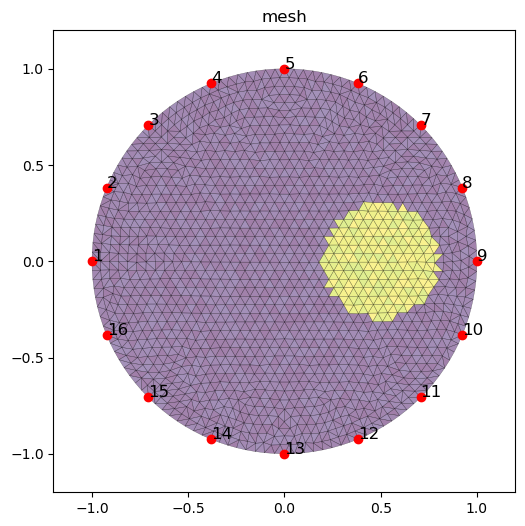

In [4]:
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [5]:
tmp["anomaly"].tolist().center

array([0.5, 0. ])

In [6]:
V_all = list()
posis_xy = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path +ele, allow_pickle=True)
    V_all.append(tmp_l["v_obj"])
    posis_xy.append(tmp_l["anomaly"].tolist().center)
    
V_all = np.array(V_all)
posis_xy = np.array(posis_xy)

100%|██████████| 1000/1000 [00:02<00:00, 499.42it/s]


In [69]:
print(V_all.shape, posis_xy.shape)

(1000, 192) (1000, 2)


## Build VAE

In [70]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [71]:
latent_dim = 4

# encoder
encoder_inputs = keras.Input(shape=(192,))

x = layers.Reshape((192,1))(encoder_inputs)
x = layers.Conv1D(64, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(32, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(16, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Conv1D(8, activation="relu", kernel_size=3,strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling(name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192)]        0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 192, 1)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 96, 64)       256         ['reshape_2[0][0]']              
                                                                                                  
 conv1d_5 (Conv1D)              (None, 48, 32)       6176        ['conv1d_4[0][0]']               
                                                                                            

In [72]:
# decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(96, activation="relu")(x)
x = layers.Reshape((12,8))(x)
x = layers.Conv1DTranspose(16, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(64, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(128, activation="relu", kernel_size=3, strides=2, padding="same")(x)
x = layers.Conv1DTranspose(1, activation="relu", kernel_size=1, strides=1, padding="same")(x)

decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                80        
                                                                 
 dense_5 (Dense)             (None, 96)                1632      
                                                                 
 reshape_3 (Reshape)         (None, 12, 8)             0         
                                                                 
 conv1d_transpose_5 (Conv1DT  (None, 24, 16)           400       
 ranspose)                                                       
                                                                 
 conv1d_transpose_6 (Conv1DT  (None, 48, 32)           1568      
 ranspose)                                                 

In [73]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [74]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [75]:
#V_all = np.expand_dims(V_all,2)
V_vae_train, V_vae_test = train_test_split(
    V_all, test_size=0.1, shuffle=True, random_state=52
)

In [76]:
print(V_vae_train.shape, V_vae_test.shape)

(900, 192) (100, 192)


In [77]:
history = vae.fit(V_vae_train, epochs=25, batch_size=64)

Epoch 1/25
15/15 [==============================] - 4s 10ms/step - loss: 0.3181 - reconstruction_loss: 0.2685 - kl_loss: 5.4232e-04
Epoch 2/25
15/15 [==============================] - 0s 11ms/step - loss: 0.1390 - reconstruction_loss: 0.1309 - kl_loss: 6.6296e-05
Epoch 3/25
15/15 [==============================] - 0s 11ms/step - loss: 0.1129 - reconstruction_loss: 0.1098 - kl_loss: 5.4236e-05
Epoch 4/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0971 - reconstruction_loss: 0.0927 - kl_loss: 1.3244e-05
Epoch 5/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0699 - reconstruction_loss: 0.0617 - kl_loss: 7.3910e-06
Epoch 6/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0361 - reconstruction_loss: 0.0321 - kl_loss: 5.7658e-06
Epoch 7/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0213 - reconstruction_loss: 0.0192 - kl_loss: 8.4221e-06
Epoch 8/25
15/15 [==============================] - 0s 10ms/step - loss: 0.0

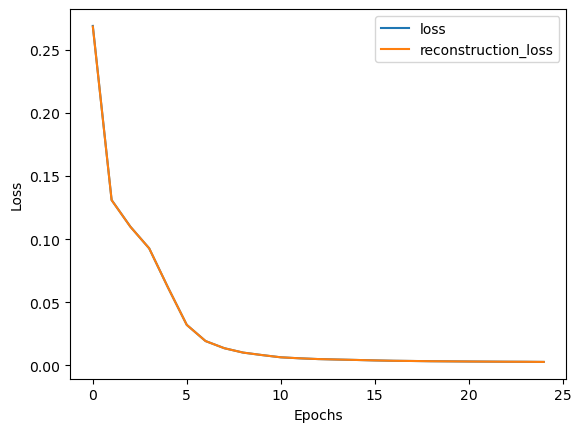

In [78]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [79]:
z_mean, _, _ = vae.encoder.predict(V_all)

32/32 [==============================] - 0s 1ms/step


In [80]:
x,y = posis_xy.T

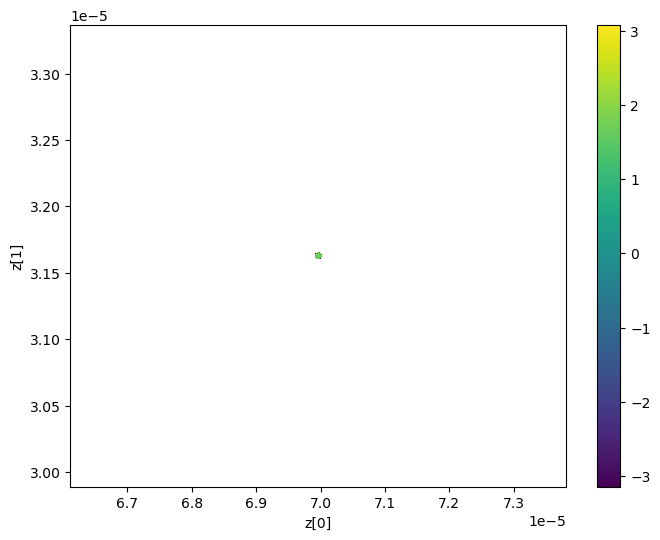

In [82]:
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.arctan2(x,y), s =10)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar(label="")
plt.show()

In [83]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
latent_space_2d = tsne.fit_transform(z_mean) # latent data

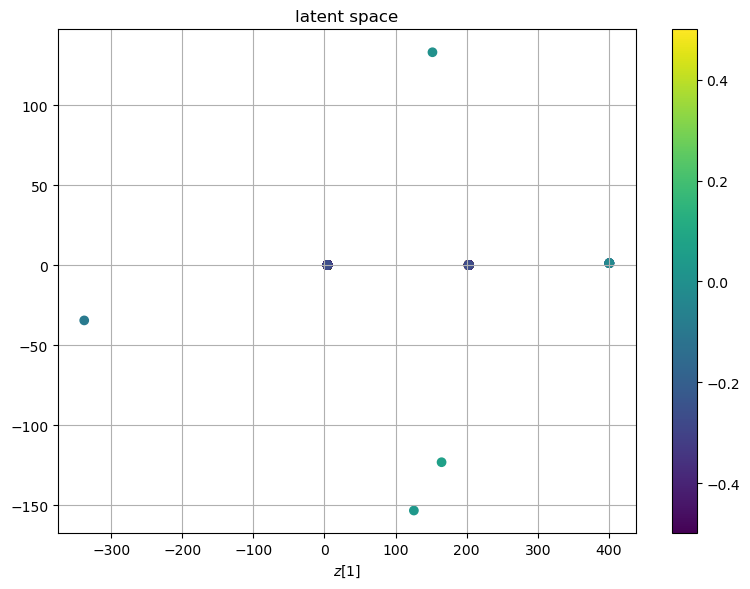

In [84]:
plt.figure(figsize=(8, 6))
plt.title("latent space")
plt.scatter(latent_space_2d[:,0],latent_space_2d[:,1], c=posis_xy[:,1])
plt.xlabel("$z[0]$")
plt.xlabel("$z[1]$")
plt.colorbar(label="")
plt.grid()
plt.tight_layout()
plt.show()

In [85]:
_,_, V_z_test = vae.encoder.predict(V_vae_test)

4/4 [==============================] - 0s 3ms/step


In [86]:
pred = vae.decoder.predict(V_z_test)

4/4 [==============================] - 0s 3ms/step


In [87]:
pred

array([[0.07123521, 0.12616397, 0.05693845, ..., 0.7673098 , 0.45187697,
        0.17961034],
       [0.08344947, 0.11846378, 0.07567522, ..., 0.77963936, 0.5091746 ,
        0.24297008],
       [0.07685541, 0.12128375, 0.05837218, ..., 0.7660522 , 0.4888344 ,
        0.22411692],
       ...,
       [0.07248172, 0.12491444, 0.05610959, ..., 0.7782141 , 0.4953359 ,
        0.2120487 ],
       [0.08488052, 0.11960909, 0.08780363, ..., 0.7521479 , 0.4957638 ,
        0.27275914],
       [0.07917726, 0.12004401, 0.06326246, ..., 0.77726734, 0.4941971 ,
        0.22171602]], dtype=float32)

<StemContainer object of 3 artists>

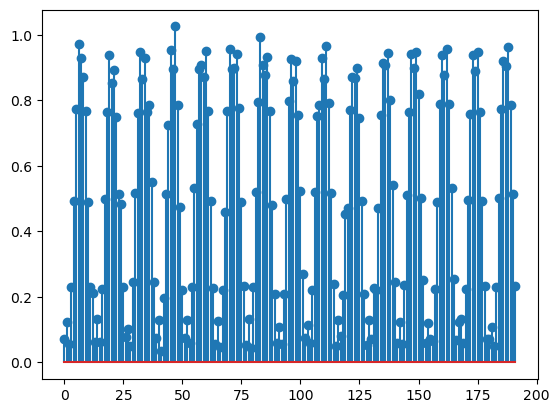

In [92]:
plt.stem(pred[10,:])

<StemContainer object of 3 artists>

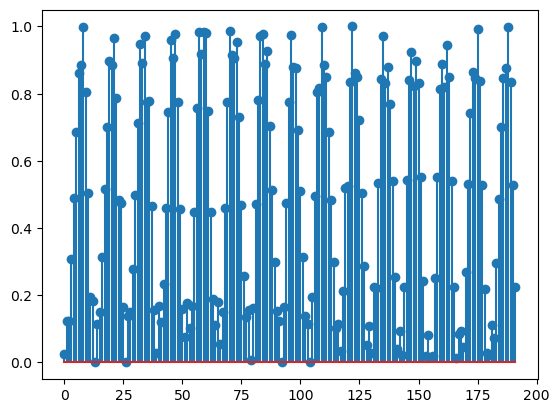

In [89]:
plt.stem(V_vae_test[0,:])

In [96]:
np.allclose(pred, V_vae_test, rtol=1)

False

In [97]:
pred

array([[0.07123521, 0.12616397, 0.05693845, ..., 0.7673098 , 0.45187697,
        0.17961034],
       [0.08344947, 0.11846378, 0.07567522, ..., 0.77963936, 0.5091746 ,
        0.24297008],
       [0.07685541, 0.12128375, 0.05837218, ..., 0.7660522 , 0.4888344 ,
        0.22411692],
       ...,
       [0.07248172, 0.12491444, 0.05610959, ..., 0.7782141 , 0.4953359 ,
        0.2120487 ],
       [0.08488052, 0.11960909, 0.08780363, ..., 0.7521479 , 0.4957638 ,
        0.27275914],
       [0.07917726, 0.12004401, 0.06326246, ..., 0.77726734, 0.4941971 ,
        0.22171602]], dtype=float32)

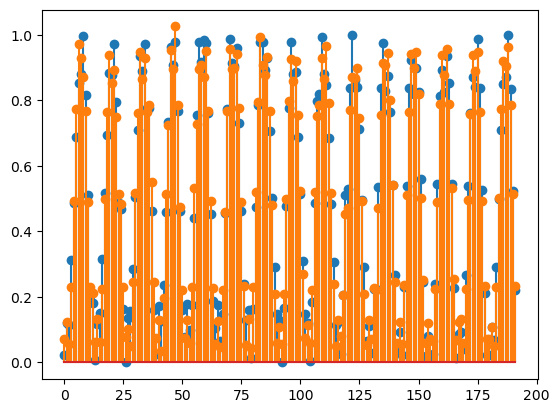

In [109]:
plt.stem(V_vae_test[10,:],"C0")
plt.stem(pred[10,:],"C1")
plt.show()